In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import colors as mcolors
import numpy as np
import scipy.integrate as intgr
import matplotlib.ticker as mtick
from itertools import product
from collections import defaultdict
from wetting_utils import *

plt.style.use('../include/aps.mplstyle')


### Radii and Elements Under Consideration

In [2]:
Rs = [4.0, 5.0, 6.0, 8.0, 10.0, 12.0]
wf_elements = ['Ar', 'Mg', 'Cs']

In [3]:
def cc(arg):
    return mcolors.to_rgba(arg,alpha=0.6)

### Load the ground state data from disk

In [4]:
verts = defaultdict(list)
poly = {}

for element in wf_elements:
    for R in Rs:
        with np.load(ψ_filename(R,element)) as f:
            rval = f['arr_0']
            radial = f['arr_1']
        normalize_psi_PIMC(radial,rval)
        rval = np.insert(rval, 0, -0.1) 
        radial = np.insert(radial, 0, 0)
        radial[-1] = 0
    
        verts[element].append(list(zip(rval, radial)))

    poly[element] = PolyCollection(verts[element],facecolors=[cc(element_colors[element])]*len(Rs),
                                   edgecolors=element_colors[element],linewidths=0.5,alpha=0.6)


Norm = 1.9943041040885479
Norm = 2.012019301825279
Norm = 2.024150715245431
Norm = 1.9800310251346966
Norm = 2.1046567393856987
Norm = 1.9415150846487308
Norm = 2.010337365927424
Norm = 1.993634737869944
Norm = 2.0064659361227046
Norm = 2.0067059874964754
Norm = 1.958938157067764
Norm = 2.016635750803403
Norm = 2.0424958295357984
Norm = 2.0093979071313233
Norm = 1.997469735916623
Norm = 1.9989870399327152
Norm = 1.9990406105038216
Norm = 2.0072822408958575


## Create the 3D Waterfall Plot

In [5]:
# Define the triangle vertices in 3D (z=0 means it's on the "bottom" plane)
triangle_vertices = np.array([
    [4.0, 4.0, 0.0],
    [11.0, 4.0, 0.0],
    [11.0, 12.0, 0.0]
])

# Prepare the triangle as a Poly3DCollection
vertstr = [list(triangle_vertices)]

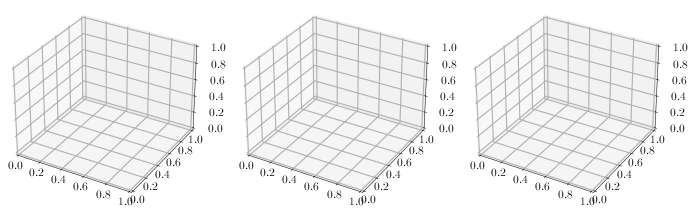

In [6]:
with plt.style.context('../include/aps.mplstyle'):
    figsize = plt.rcParams['figure.figsize']
    fig= plt.figure(figsize=(2*figsize[0],figsize[1]),constrained_layout=True)

    ax1 = fig.add_subplot(131,projection='3d')
    ax1.add_collection3d(poly['Ar'], zs=Rs, zdir='y')
    triangle1 = Poly3DCollection(vertstr, facecolor='#C0C0C0', edgecolor='#C0C0C0')
    ax1.add_collection3d(triangle1)
    ax1.set_xlabel(r'$r$ [Å]',labelpad=-10)
    ax1.set_xlim3d(-0.1, 11)
    ax1.set_ylabel(r'$R$ [Å]',labelpad=-6)
    ax1.set_ylim3d(4.0, 12.0)
    ax1.set_zlim3d(0, 0.0125)
    ax1.tick_params(pad=-5)
    ax1.tick_params(axis='z',pad=2)
    ax1.text(3,12.0,0.007,r'$^4$He/Ar','x',color='k')
    
    ax2 = fig.add_subplot(132,projection='3d')
    triangle2 = Poly3DCollection(vertstr, facecolor='#C0C0C0', edgecolor='#C0C0C0')
    ax2.add_collection3d(poly['Mg'], zs=Rs, zdir='y')
    ax2.add_collection3d(triangle2)
    ax2.set_xlabel(r'$r$ [Å]',labelpad=-10,size='x-small')
    ax2.set_xlim3d(-0.1, 11)
    ax2.set_ylabel(r'$R$ [Å]',labelpad=-6,size='x-small')
    ax2.set_ylim3d(4.0, 12.0)
    ax2.set_zlim3d(0, 0.02)
    ax2.text(3,12.0,0.009,r'$^4$He/Mg','x',color='k')
    ax2.tick_params(pad=-5)
    ax2.tick_params(axis='z',pad=2)

    ax3 = fig.add_subplot(133,projection='3d')
    triangle3 = Poly3DCollection(vertstr, facecolor='#C0C0C0', edgecolor='#C0C0C0')
    ax3.add_collection3d(poly['Cs'], zs=Rs, zdir='y')
    ax3.add_collection3d(triangle3)
    ax3.set_xlabel(r'$r$ [Å]',labelpad=-10)
    ax3.set_xlim3d(-0.1, 11)
    ax3.set_ylabel(r'$R$ [Å]',labelpad=-6)
    ax3.set_ylim3d(4.0, 12.0)
    ax3.set_zlim3d(0, 0.03)
    ax3.text(3,12.0,0.012,r'$^4$He/Cs','x',color='k')
    ax3.tick_params(pad=-5)
    ax3.tick_params(axis='z',pad=2)
    
    # Add panel labels
    ax1.text2D(0.1, 0.85, "(a)", transform=ax1.transAxes,ha="left", va="bottom")
    ax2.text2D(0.1, 0.85, "(b)", transform=ax2.transAxes,ha="left", va="bottom")
    ax3.text2D(0.1, 0.85, "(c)", transform=ax3.transAxes,ha="left", va="bottom")

    # Add labels for the density
    ax1.text2D(0.85, 0.82, r"$\varrho(r)\;\; [{\rm\AA^{-3}}]$", transform=ax1.transAxes,ha="left", va="bottom")
    ax2.text2D(0.84, 0.82, r"$\varrho(r)\;\; [{\rm\AA^{-3}}]$", transform=ax2.transAxes,ha="left", va="bottom")
    ax3.text2D(0.83, 0.82, r"$\varrho(r)\;\; [{\rm\AA^{-3}}]$", transform=ax3.transAxes,ha="left", va="bottom")
    
    plt.savefig('../figures/Waterfalls.pdf')
    
    ax1.cla()
    ax2.cla()
    ax3.cla()